<a href="https://colab.research.google.com/github/amirhoseinoveis/GradCAM-with-MSTAR/blob/main/GradCAM_with_MSTAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import tensorflow as tf
from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib
import matplotlib.pyplot as plt
import os
from tensorflow.keras import losses, layers
import keras
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import matplotlib.pyplot as plt

tf.random.set_seed(42)

In [214]:
github_url = 'https://github.com/amirhoseinoveis/GradCAM-with-MSTAR/raw/refs/heads/main/mstar_3cl_32by32.npz'
# Download the file using wget
path = '/content/mstar_3cl_32by32.npz'
os.system(f'wget {github_url} -O {path}')

# Load the data using np.load
with np.load(path) as data_mstar:
    x_train_mstar = data_mstar['x_train']
    y_train_mstar = data_mstar['y_train']
    x_test_mstar = data_mstar['x_test']
    y_test_mstar = data_mstar['y_test']


In [216]:
inputs = Input(shape=(32,32,1),name="Input")
x = Conv2D(128, 3, activation="relu", padding='same',name='Conv1')(inputs)
x = MaxPooling2D(2,name='Pool1')(x)
x = Conv2D(32, 3, activation="relu",padding='same',name='Conv3')(x)
x = MaxPooling2D(2,name='Pool2')(x)
x = Conv2D(16, 3, activation="relu",padding='same',name='Conv4')(x)
x = MaxPooling2D(2,name='Pool3')(x)

x = Flatten(name='Vectorize')(x)
outputs= Dense(3,name='FC',activation="softmax")(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()




hist = model.fit(
x_train_mstar,
to_categorical(y_train_mstar, 3),  # One-hot encode your labels
batch_size=32,
epochs=30,
validation_split=0.15,
shuffle='off',
)
y_hat=model.predict(x_test_mstar)#test the model, prob.


#classification_report
CM=confusion_matrix(y_true=y_test_mstar,y_pred=y_hat.argmax(1))
# Display confusion matrix
print("Confusion Matrix:")
print(CM)
print("classification_report:")

print(classification_report(y_true=y_test_mstar,y_pred=y_hat.argmax(1)))


Model: "functional_143"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 32, 32, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv3 (Conv2D)                  │ (None, 16, 16, 32)     │        36,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv4 (Conv2D)                  │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool3 (MaxPooling2D)            │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Vectorize (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC (Dense)                      │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,571 (170.20 KB)

 Trainable params: 43,571 (170.20 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - acc: 0.3682 - loss: 1.0687 - val_acc: 0.5429 - val_loss: 0.9986
Epoch 2/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - acc: 0.5921 - loss: 0.9418 - val_acc: 0.5524 - val_loss: 0.8235
Epoch 3/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.6434 - loss: 0.7474 - val_acc: 0.7143 - val_loss: 0.6241
Epoch 4/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.7195 - loss: 0.6052 - val_acc: 0.8286 - val_loss: 0.4956
Epoch 5/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - acc: 0.8159 - loss: 0.4663 - val_acc: 0.8286 - val_loss: 0.4031
Epoch 6/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8910 - loss: 0.3193 - val_acc: 0.8667 - val_loss: 0.3325
Epoch 7/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9347 - loss: 0.2007 - val_acc: 0.9238 - val_loss: 0.1866
Epoch 8/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.9762 - loss: 0.1115 - val_acc: 1.0000 - val_loss: 0.1030
Epoch 9/30
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - acc: 0.9909 - los

In [208]:
def get_gradcam_heatmap(model, image, class_idx, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.expand_dims(image, axis=0))
        loss = predictions[:, class_idx]

    # Gradient of the output neuron (target class) with respect to conv layer output
    grads = tape.gradient(loss, conv_outputs)[0]

    # Mean intensity of the gradient over each feature map channel
    weights = tf.reduce_mean(grads, axis=(0, 1))

    # Weighted sum of feature maps
    cam = tf.reduce_sum(tf.multiply(weights, conv_outputs[0]), axis=-1)

    # Apply ReLU
    cam = tf.nn.relu(cam).numpy()

    # Normalize between 0 and 1
    cam -= cam.min()
    cam /= cam.max() + 1e-8

    return cam
def show_gradcam_overlay(input_image, heatmap, true_class=None, pred_class=None, alpha=0.5):
    """
    Displays original input, Grad-CAM heatmap, and overlay with class info.

    Args:
        input_image (np.array): Input image (H, W, 1) or (H, W, 3)
        heatmap (np.array): Grad-CAM heatmap (range 0–1)
        true_class (str or int): True class label (optional)
        pred_class (str or int): Predicted class label (optional)
        alpha (float): Blending factor for overlay
    """
    # Scale and resize heatmap
    heatmap = np.uint8(255 * heatmap)
    heatmap_resized = cv2.resize(heatmap, (input_image.shape[1], input_image.shape[0]))
    heatmap_colored_bgr = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored_bgr, cv2.COLOR_BGR2RGB)

    # Prepare input image and convert to 3-channel RGB
    if input_image.shape[-1] == 1:
        img_uint8 = np.uint8(255 * input_image.squeeze())
        input_image_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_GRAY2BGR)
        input_display = input_image.squeeze()
        cmap = 'gray'
    elif input_image.shape[-1] == 3:
        input_image_rgb = np.uint8(255 * input_image)
        input_display = input_image
        cmap = None
    else:
        raise ValueError("Input image must have 1 or 3 channels.")

    # Create overlay image
    overlay_bgr = cv2.addWeighted(heatmap_colored_bgr, alpha, input_image_rgb, 1 - alpha, 0)
    overlay = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    # Build figure title
    title_text = "Grad-CAM Visualization"
    if true_class is not None or pred_class is not None:
        title_text += f"\nTrue: {true_class} | Predicted: {pred_class}"

    # Plot
    plt.figure(figsize=(15, 5))
    plt.suptitle(title_text, fontsize=14)

    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(input_display, cmap=cmap)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(heatmap_colored)
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Grad-CAM Overlay")
    plt.imshow(overlay)
    plt.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # leave space for suptitle
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['Input']]
Received: inputs=Tensor(shape=(1, 32, 32, 1))
  warnings.warn(msg)


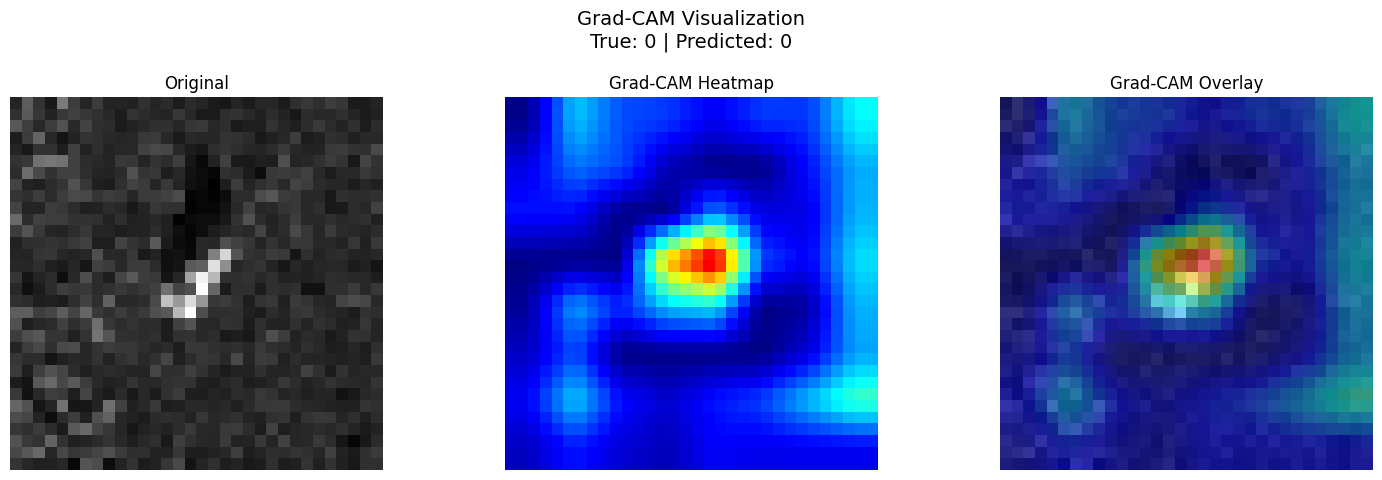

In [217]:
img_idx =10
input_image = x_test_mstar[img_idx]  # shape: (H, W, 1)
true_label = y_test_mstar[img_idx]
preds = model.predict(np.expand_dims(input_image, axis=0))
pred_class = np.argmax(preds[0])

# Select the last conv layer (modify as needed)
last_conv_layer = "Conv4"

# Get heatmap
heatmap = get_gradcam_heatmap(model, input_image, pred_class, last_conv_layer)


show_gradcam_overlay(input_image, heatmap, true_class=true_label, pred_class=pred_class)
